In [1]:
import pickle
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures


gleap_target = md.load("../2_md-preparation/gleap.target.gro")
target_indices = gleap_target.topology.select("resid 0 to 48")

protein_indices = gleap_target.topology.select("resid 5 to 48")
protein_region_indices = {
    "idr": gleap_target.topology.select("resid 5 to 14"),
    "structured": gleap_target.topology.select("resid 15 to 48"),
}
protein_min_index = min(protein_indices)

rna_indices = gleap_target.topology.select("resid 0 to 4")
rna_min_index = min(rna_indices)

pickle_dir = "./pickle-cache/hbond"

if False:
    def worker(trial):
        print(trial, "start")
        interactions = np.zeros((len(protein_indices), len(rna_indices), 1200))
        com_dists_hist = np.zeros(1200)
        cmd_com_dists_average = 0
        cmd_interactions = np.zeros((len(protein_indices), len(rna_indices), 8000))

        xtc = None
        if trial == "cmd":
            xtc = md.load("../6_prd-1/prd.skip10.whole.cluster.xtc", top=gleap_target, atom_indices=target_indices)[2001:]
        else:
            xtc = md.load(f"./trial{str(trial+1).zfill(3)}/prd.target.trjcat-all.mol.pbc.skip10.xtc", top=gleap_target)
    
        protein_coms = md.compute_center_of_mass(xtc.atom_slice(protein_indices))
        rna_coms     = md.compute_center_of_mass(xtc.atom_slice(    rna_indices))
    
        com_dists = np.linalg.norm(rna_coms-protein_coms, axis=1)
        com_dists_hist = np.zeros(1200)
        for com_dist in com_dists:
            com_dist_bin = int(com_dist*100)
            com_dists_hist[com_dist_bin]+=1
    
        for timestep in range(xtc.n_frames):
            com_dist_bin = int(com_dists[timestep]*100)
            hbonds = md.baker_hubbard(xtc[timestep], distance_cutoff=0.3, angle_cutoff=120)
            for pair in hbonds:
                donor_idx = pair[0]
                hydrogen_idx = pair[1]
                acceptor_idx = pair[2]
    
                protein_idx = 0
                rna_idx = 0
                if hydrogen_idx in protein_indices and acceptor_idx in rna_indices:
                    protein_idx = hydrogen_idx
                    rna_idx = acceptor_idx
                elif hydrogen_idx in rna_indices and acceptor_idx in protein_indices:
                    protein_idx = acceptor_idx
                    rna_idx = hydrogen_idx
                else:
                    continue
                if trial == "cmd":
                    cmd_interactions[protein_idx-protein_min_index][rna_idx][timestep] += 1
                else:
                    interactions[protein_idx-protein_min_index][rna_idx][com_dist_bin] += 1

        if trial == "cmd":
            cmd_com_dists_average = np.average(com_dists)
            pickle.dump(cmd_com_dists_average, open(f"{pickle_dir}/cmd_com_dists_average.pickle", "wb"))
            nonzero_idxs = cmd_interactions.nonzero()
            nonzero_vals = cmd_interactions[nonzero_idxs]
            pickle.dump([nonzero_idxs, nonzero_vals], open(f"{pickle_dir}/cmd_interactions.pickle", "wb"))
        else:  
            nonzero_idxs = interactions.nonzero()
            nonzero_vals = interactions[nonzero_idxs]
            pickle.dump([nonzero_idxs, nonzero_vals], open(f"{pickle_dir}/pacs_interactions_{trial}.pickle", "wb"))
            pickle.dump(com_dists_hist, open(f"{pickle_dir}/pacs_com_dists_hist_{trial}.pickle", "wb"))
        print(trial, "completed")

    if not os.path.exists(pickle_dir):
        os.mkdir(pickle_dir)
    trials = ["cmd"]
    trials.extend(range(32))
    for _ in concurrent.futures.ProcessPoolExecutor(max_workers=20).map(worker, trials):
        pass

pacs_interactions = np.zeros((32, len(protein_indices), len(rna_indices), 1200))
pacs_com_dists_hist = np.zeros((32, 1200))
for trial in range(len(pacs_interactions)):
    nonzero_idxs, nonzero_vals = pickle.load(open(f"{pickle_dir}/pacs_interactions_{trial}.pickle", "rb"))
    pacs_interactions[trial][nonzero_idxs] = nonzero_vals
    pacs_com_dists_hist[trial] = pickle.load(open(f"{pickle_dir}/pacs_com_dists_hist_{trial}.pickle", "rb"))
cmd_com_dists_average = pickle.load(open(f"{pickle_dir}/cmd_com_dists_average.pickle", "rb"))
cmd_interactions = np.zeros((len(protein_indices), len(rna_indices), 8000))
nonzero_idxs, nonzero_vals = pickle.load(open(f"{pickle_dir}/cmd_interactions.pickle", "rb"))
cmd_interactions[nonzero_idxs] = nonzero_vals

cmd_com_dists_average 1.0243714360087497
average 0 0.573625
average 0 0.099
average 1 0.3455
average 1 5.078125
average 2 0.0525
average 2 5.684125
average 3 0.016125
average 3 2.958875
average 4 0.094
average 4 0.234875


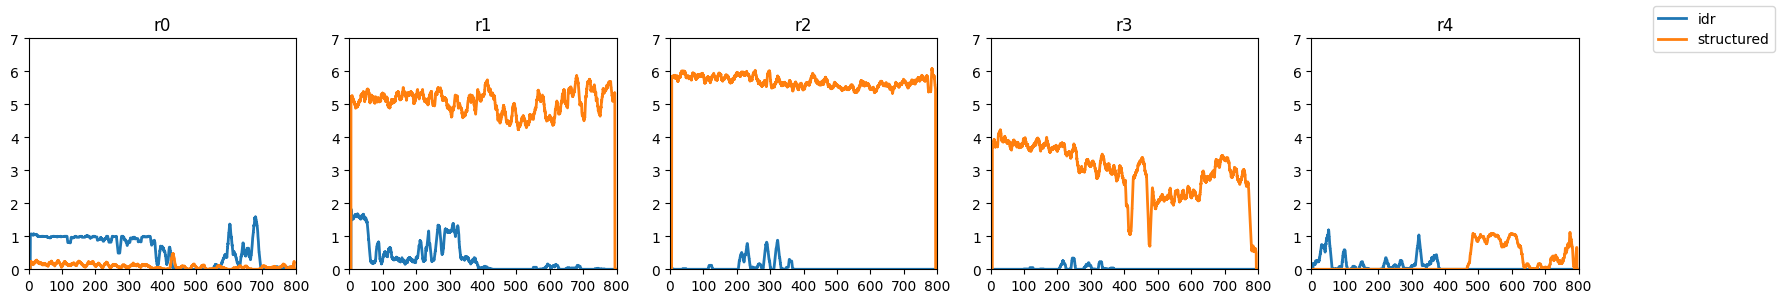

In [2]:
ymax = 7

print("cmd_com_dists_average", cmd_com_dists_average)
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 3)

for rna_res_idx in range(0, 5):
    rna_res_atom_idxs = gleap_target.topology.select(f"resid {rna_res_idx}")
    min_rna_res_atom_idx = min(rna_res_atom_idxs)
    max_rna_res_atom_idx = max(rna_res_atom_idxs)

    for region_name, region_indices in protein_region_indices.items():
        sum_cmd_interactions = np.sum(np.sum(cmd_interactions[region_indices-protein_min_index,min_rna_res_atom_idx-rna_min_index:max_rna_res_atom_idx+1-rna_min_index,:], axis=0), axis=0)
        smoothed_interactions = np.zeros(len(sum_cmd_interactions))
        for timestep in range(50, len(sum_cmd_interactions)-50):
            smoothed_interactions[timestep] = np.average(sum_cmd_interactions[timestep-50:timestep+50])
            
        print("average", rna_res_idx, np.average(sum_cmd_interactions))
        ax[rna_res_idx-0].set_title(f"r{rna_res_idx-0}")
        ax[rna_res_idx-0].set_xticks([val*1000 for val in range(9)], [val*100 for val in range(9)])
        if rna_res_idx == 0:
            ax[rna_res_idx-0].plot(smoothed_interactions, linewidth=2, label=region_name)
        else:
            ax[rna_res_idx-0].plot(smoothed_interactions, linewidth=2)
        ax[rna_res_idx-0].set_xlim(0, 8000)
        ax[rna_res_idx-0].set_ylim(0, ymax)
fig.legend()

/tmp/ipykernel_2052578/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052578/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052578/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052578/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
/tmp/ipykernel_2052578/52205945.py:21: RuntimeWarning: invalid value encountered in divide
  ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidt

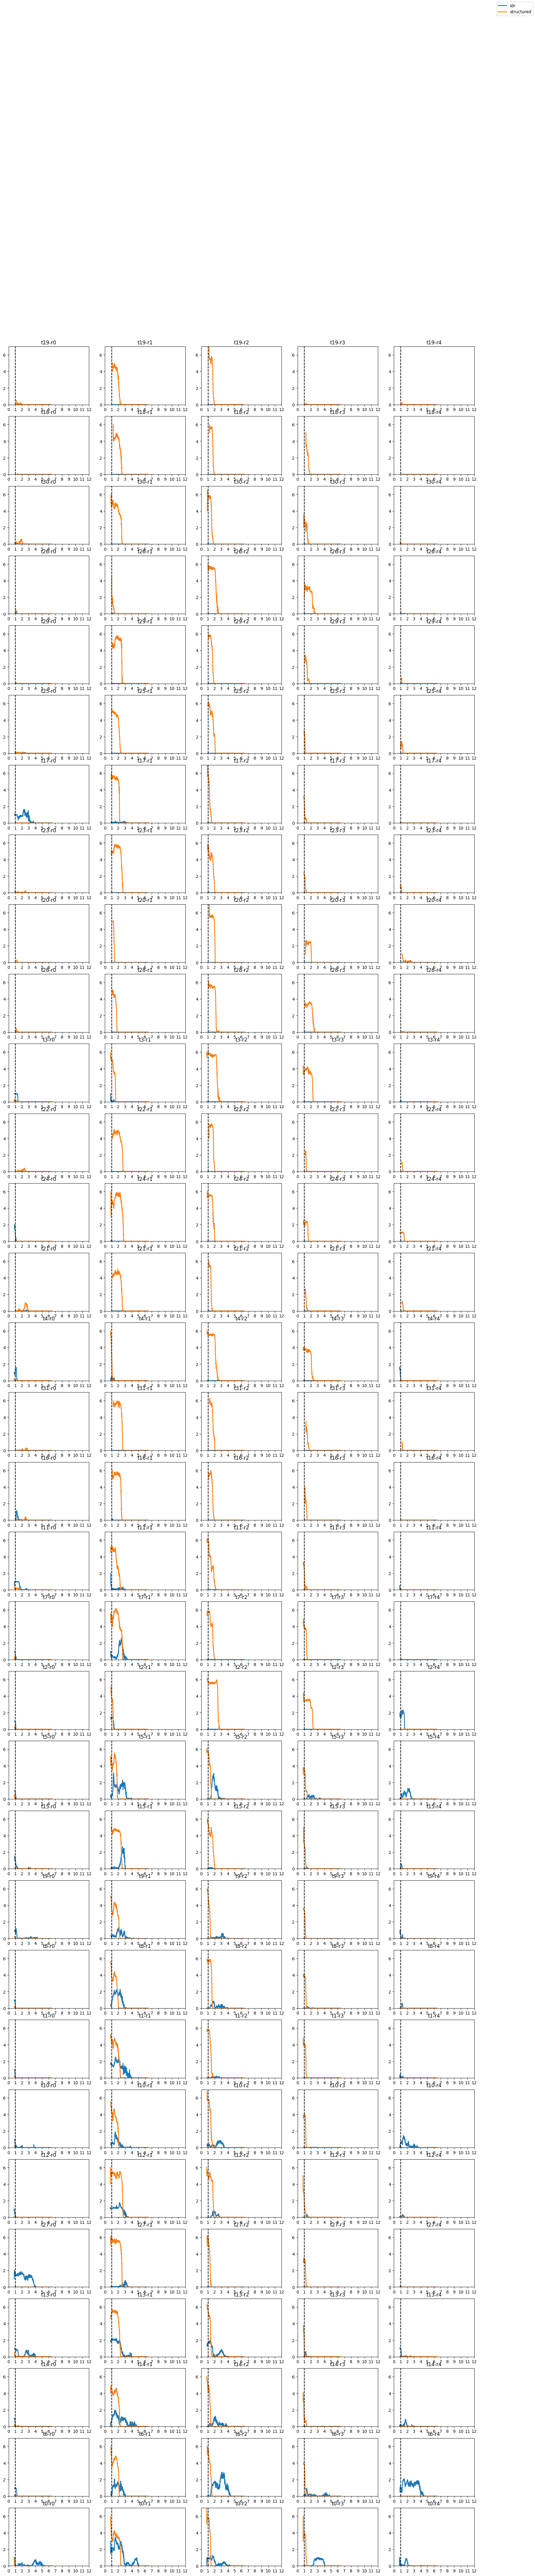

In [3]:
fig, ax = plt.subplots(len(pacs_interactions), 5)
fig.set_size_inches(20, 3*len(pacs_interactions))

pacs_g_stds_ordered = [(19, -3.4383222715529755), (18, -4.064455225716387), (30, -4.48612942287419), (26, -4.624781171615315), (29, -4.683410979897177), (25, -4.933236290336003), (17, -5.118835703750063), (23, -5.521004724688876), (20, -5.522645853979005), (28, -5.678007148970815), (3, -5.678261127542603), (22, -5.93031226290956), (24, -5.966115973285376), (21, -6.022353770917038), (4, -6.125216702283895), (31, -6.224672440089437), (16, -6.2739255360777175), (11, -6.287913880137764), (7, -6.520357463407324), (2, -6.873004446601907), (5, -7.305598346706374), (15, -7.425622465131511), (9, -7.442437949729127), (8, -7.627195073788825), (1, -8.100851065532183), (10, -8.265797922888845), (12, -8.413117936507568), (27, -8.424109846287314), (13, -9.041054919020613), (14, -9.094471340851847), (6, -9.28998243345896), (0, -10.433896108969531)]

ax_row = 0
for trial, g_std in pacs_g_stds_ordered:
    for region_name, region_indices in protein_region_indices.items():
        rna_interactions_sum = np.zeros((28, 1200))
        for rna_idx in rna_indices:
            rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
            if not (0 <= rna_res_idx <= 4):
                continue
            for protein_idx in region_indices:
                rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
    
        for rna_res_idx in range(0, 5):
            if trial == 0 and rna_res_idx == 0:
                ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2, label=region_name)
            else:
                ax[ax_row][rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/pacs_com_dists_hist[trial], linewidth=2)
            ax[ax_row][rna_res_idx-0].set_title(f"t{trial}-r{rna_res_idx-0}")
            ax[ax_row][rna_res_idx-0].set_xticks([val*100 for val in range(13)], [val for val in range(13)])
            ax[ax_row][rna_res_idx-0].set_ylim(0, ymax)
            ax[ax_row][rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
    ax_row += 1
fig.legend()

/tmp/ipykernel_2052578/3804007334.py:36: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, label=region_name, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/3804007334.py:38: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_nam

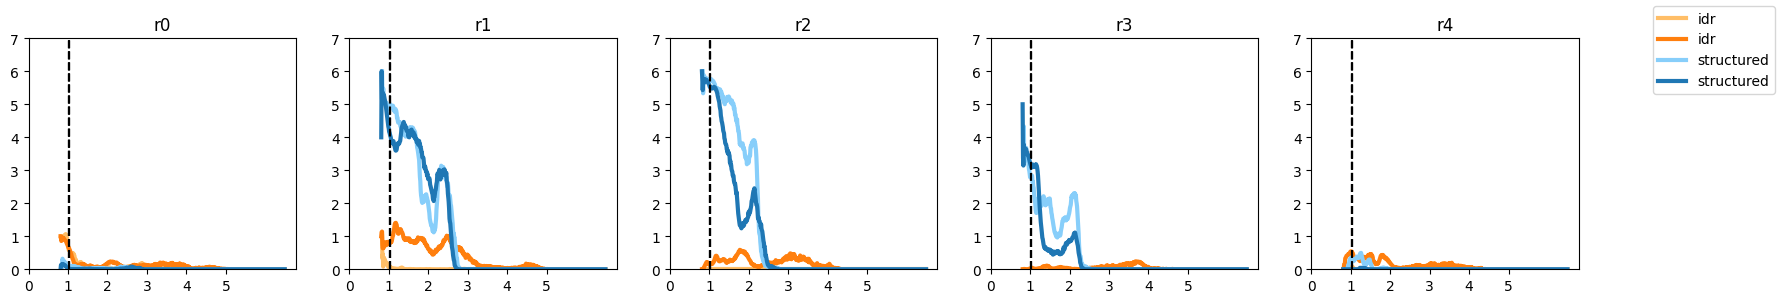

In [4]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 3)

colors = {
    "idr": {
        "high": "#FFBE67",
        "low": "tab:orange",
    },
    "structured": {
        "high": "lightskyblue",
        "low": "tab:blue",
    },
}

pacs_category = {"high": [], "low": []}
for i in range(len(pacs_g_stds_ordered)):
    if i < 13:
        pacs_category["high"].append(pacs_g_stds_ordered[i][0])
    else:
        pacs_category["low"].append(pacs_g_stds_ordered[i][0])

for region_name, region_indices in protein_region_indices.items():
    for category_name, trials in pacs_category.items():
        rna_interactions_sum = np.zeros((28, 1200))
        for trial in trials:
            for rna_idx in rna_indices:
                rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
                if not (0 <= rna_res_idx <= 4):
                    continue
                for protein_idx in region_indices:
                    rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
                        
        for rna_res_idx in range(0, 5):
            ax[rna_res_idx-0].set_title(f"r{rna_res_idx-0}")
            if rna_res_idx == 0:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, label=region_name, c=colors[region_name][category_name])
            else:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=3, c=colors[region_name][category_name])
            ax[rna_res_idx-0].set_xticks([val*100 for val in range(6)], [val for val in range(6)])
            ax[rna_res_idx-0].set_ylim(0, ymax)
            ax[rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
fig.legend()

/tmp/ipykernel_2052578/2398954692.py:20: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, label=region_name, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/2398954692.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/2398954692.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
/tmp/ipykernel_2052578/2398954692.py:22: RuntimeWarning: invalid value encountered in divide
  ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_nam

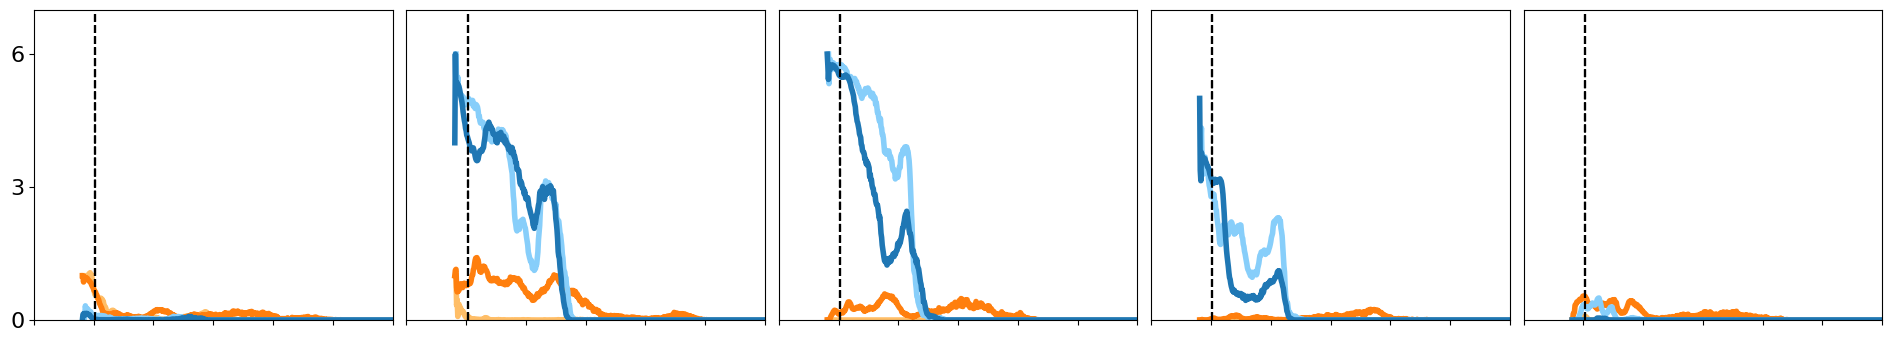

In [5]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(19, 3.5)

for region_name, region_indices in protein_region_indices.items():
    for category_name, trials in pacs_category.items():
        rna_interactions_sum = np.zeros((5, 1200))
        for trial in trials:
            for rna_idx in rna_indices:
                rna_res_idx = gleap_target.topology.atom(rna_idx).residue.index
                if not (0 <= rna_res_idx <= 4):
                    continue
                for protein_idx in region_indices:
                    rna_interactions_sum[rna_res_idx-0] += pacs_interactions[trial][protein_idx-protein_min_index][rna_idx-rna_min_index]
                        
        for rna_res_idx in range(0, 5):
            if rna_res_idx != 0:
                ax[rna_res_idx].set_yticks([])
            ax[0].set_yticks([0, 3, 6,], [0, 3, 6,], fontsize=16)
            if rna_res_idx == 0:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, label=region_name, c=colors[region_name][category_name])
            else:
                ax[rna_res_idx-0].plot(rna_interactions_sum[rna_res_idx-0]/np.sum(pacs_com_dists_hist[trials], axis=0), linewidth=4, c=colors[region_name][category_name])
            ax[rna_res_idx].set_xticks([val*100 for val in range(7)], ["" for val in range(7)], fontsize=16)
            ax[rna_res_idx].set_xlim(0, 600)
            ax[rna_res_idx-0].set_ylim(0, 7)
            ax[rna_res_idx-0].axvline(cmd_com_dists_average*100, color="black", linestyle="--")
fig.tight_layout(pad=1, w_pad=1, h_pad=0.5)

In [6]:
for protein_res_idx in range(5, 48):
    protein_atom_idxs = gleap_target.topology.select(f"resid {protein_res_idx}")
    for protein_atom_idx in protein_atom_idxs:
        sum_interactions = np.sum(pacs_interactions[:,protein_atom_idx-protein_min_index,:,:])
        if sum_interactions != 0:
            print(gleap_target.topology.atom(protein_atom_idx), sum_interactions)

ACE6-O 2637.0
GLY7-N 159.0
GLY7-H 22277.0
GLY7-O 6955.0
GLY8-N 721.0
GLY8-H 78911.0
GLY8-O 9250.0
GLY9-N 636.0
GLY9-H 98693.0
GLY9-O 9294.0
GLY10-N 428.0
GLY10-H 40726.0
GLY10-O 5540.0
GLY11-N 417.0
GLY11-H 33338.0
GLY11-O 10186.0
GLY12-N 547.0
GLY12-H 63669.0
GLY12-O 104910.0
GLN13-N 312.0
GLN13-H 320.0
GLN13-OE1 616.0
GLN13-NE2 224.0
GLN13-HE21 978.0
GLN13-HE22 2266.0
GLN13-O 176976.0
GLN14-N 527.0
GLN14-H 11574.0
GLN14-OE1 350.0
GLN14-NE2 89.0
GLN14-HE21 57.0
GLN14-HE22 159.0
GLN14-O 2.0
ARG15-N 12992.0
ARG15-H 61986.0
ARG15-NE 308.0
ARG15-HE 12885.0
ARG15-NH1 256.0
ARG15-HH11 102573.0
ARG15-HH12 49117.0
ARG15-NH2 421.0
ARG15-HH21 12508.0
ARG15-HH22 48865.0
ARG15-O 10.0
ALA16-N 17.0
ALA16-H 527.0
ALA16-O 3441.0
GLY17-H 170.0
ASP18-N 4.0
ASP18-H 1770.0
ASP18-OD1 944658.0
ASP18-OD2 1097281.0
ASN28-OD1 302485.0
ASN28-ND2 65644.0
ASN28-HD21 430693.0
ASN28-HD22 4.0
MET29-N 90.0
MET29-H 12.0
MET29-O 835305.0
ASN30-N 175.0
ASN30-OD1 235.0
ASN30-O 2.0
PHE31-N 2375.0
PHE31-H 536620.0
SER32-N

In [7]:
pacs_interactions_average = np.average(pacs_interactions[:,:,:,:150], axis=3)
pacs_interactions_average.dump("pacs_interactions_average.numpy")
pacs_com_dists_hist.dump("pacs_com_dists_hist.numpy")